# Credit card fraud detection through isolation forest

### Import Data

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.append("/Isolation-Forest-For-Fraud-Detection/src/")
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from src.preprocessing.data import read_all_trx, train_test_split_transactions
from src.preprocessing.features import create_feature_matrix
from src.model.performance import evaluate_model, random_search_cv,time_window_cv
from src.preprocessing.helpers import scenario_sample
from src.plotting_functions.plot_results import * 

from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

In [3]:
#______________________________ DATA______________________________________
start = '2018-04-01'
end = '2018-09-30'
calendar = pd.date_range(start, end, inclusive="both").strftime('%Y-%m-%d')
root = "https://github.com/Fraud-Detection-Handbook/simulated-data-raw/blob/main/data/"
path_data = [f"{root}{date}.pkl?raw=true" for date in calendar]
transactions_df = read_all_trx(path_data).sort_values('TX_DATETIME').reset_index(drop=True)
scenario_1 = transactions_df.loc[transactions_df["TX_FRAUD_SCENARIO"] == 1]
scenario_2 = transactions_df.loc[transactions_df["TX_FRAUD_SCENARIO"] == 2]
scenario_3 = transactions_df.loc[transactions_df["TX_FRAUD_SCENARIO"] == 3]
#_________________________________________________________________________

Execution time: 157.75792503356934 seconds


In [ ]:
scenario_1.head()

In [ ]:
transactions_df.shape

### Creating Features

In [ ]:
#__________________________ FEATURES _________________________________
X = create_feature_matrix(transactions_df,windows_size_in_days = [1,5,7,15,30],delay_period=7)
target = "TX_FRAUD"

index = "TX_DATETIME"

train_period = "2018-07-01"

customer_features = [i for i in X.columns if "CUSTOMER_ID_" in i]

flag_features = [i for i in X.columns if "TX_FLAG_" in i]

terminal_features = [i for i in X.columns if "TERMINAL_ID_" in i]

time_features = ['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_MONTH', 'TX_DAY', 'TX_HOUR', 'TX_MINUTE', 'TX_DURING_WEEKEND',
                 'TX_DURING_NIGHT']

helper_columns = ['TX_FRAUD', 'TX_FRAUD_SCENARIO', 'TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID']

features = ['TX_AMOUNT'] + flag_features + terminal_features + customer_features + time_features
#___________________________________________________________________

### Cross Validation in Time and Features

In [ ]:
model = IsolationForest()
#________________________ FEATURE INDEPENDENT SPLIT _________________________
basic = ['TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']
features = ['TX_AMOUNT'] + flag_features + terminal_features + customer_features + time_features
auc_are_feat_type  = pd.DataFrame()
for feats in [basic,customer_features,time_features,terminal_features,features]:
    # Reports Performance
    auc_are_feat_type = pd.concat([auc_are_feat_type,time_window_cv(transactions_df,model,feats)],0)

indexlist = []
for feat in ["raw_features", "customer_features", "time_features", "terminal_features","total_features"]:
    for time in range(1, 3):
        indexname = feat + f"_time_folder_{time}"
        indexlist.append(indexname)
auc_are_feat_type.index = indexlist

validation_values  = auc_are_feat_type["validation"].explode()[0::3]
validation_values.name = "AUC"
validation_values.index = indexlist
auc_are_feat_type = pd.concat([auc_are_feat_type,validation_values],1)

In [ ]:
aucs = auc_are_feat_type["AUC"].astype(float).round(3)
auc_means = {
    'Basic Features': (aucs["raw_features_time_folder_1"], aucs["raw_features_time_folder_2"]),
    'Customer Features':  (aucs["customer_features_time_folder_1"], aucs["customer_features_time_folder_2"]),
    'Time Features':  (aucs["time_features_time_folder_1"], aucs["time_features_time_folder_2"]),
    'Terminal Features':  (aucs["terminal_features_time_folder_1"], aucs["terminal_features_time_folder_2"]),
    'Total Features':   (aucs["total_features_time_folder_1"], aucs["total_features_time_folder_2"])
}

colorad = ["#457b9d","#e0fbfc", "#98c1d9", "#3d5a80","#293241"]
keycol = ['Basic Features','Customer Features','Time Features','Terminal Features','Total Features']
color_p = {k:v for k,v in zip(keycol,colorad)}

time = ("Time Window 1", "Time Window 2")
result_fig = plot_cv_results(auc_means,time,color_p,save=False)
result_fig.show()

### Fraud Scenario Analysis

In [ ]:
model = IsolationForest()
#________________________ SCENARIO  SPLIT ___________________________________
scenario_sensitivity = []
data_scenarios = []
for scenario in transactions_df["TX_FRAUD_SCENARIO"].unique()[1:]:
    scenario_x = scenario_sample(transactions_df,scenario)
    X_train,X_test,y_train,y_test = train_test_split_transactions(create_feature_matrix(scenario_x,
                                                                                        windows_size_in_days=[1, 5, 7, 15,30],
                                                                                        delay_period=7),
                                                                  features,
                                                                  train_start="2018-04-01", train_end="2018-07-01",
                                                                  test_start="2018-08-01",  test_end="2018-09-01",
                                                                  target="TX_FRAUD")
    
    
    # Fitting the model
    model.fit(X_train[features])
    # Reports Performance
    benchmark = evaluate_model(model, X_test, y_test)
    scenario_sensitivity.append(benchmark)
    data_scenarios.append([X_train,X_test,y_train,y_test,model])

    
scenario_sensitivity = pd.concat(scenario_sensitivity,axis=1).T
scenario_sensitivity.index = [f"scenario_{i}" for i in range(1,4)]
data_scenarios_dict = {k:v for k,v in zip([f"scenario_{i}" for i in range(1,4)],data_scenarios) } 
scenario_sensitivity
#____________________________________________________________________________

In [ ]:
plot_roc_scenarios(data_scenarios_dict).show()

### Stream of Transactions Scoring

In [4]:
import datetime 
user = 27
user_trx_total = transactions_df.loc[transactions_df["CUSTOMER_ID"]==user,:].copy().reset_index(drop=True)

In [ ]:
transaction_period = transactions_df.loc[(transactions_df["TX_DATETIME"].dt.date>datetime.date(2018,4,1)) & ( transactions_df["TX_DATETIME"].dt.date<datetime.date(2018,6,1)),:]
X_train = create_feature_matrix(transaction_period,windows_size_in_days = [1,5,7,15,30],delay_period=7)
target = "TX_FRAUD"
model = IsolationForest()

In [6]:
target = "TX_FRAUD"

index = "TX_DATETIME"

train_period = "2018-07-01"

customer_features = [i for i in X_train.columns if "CUSTOMER_ID_" in i]

flag_features = [i for i in X_train.columns if "TX_FLAG_" in i]

terminal_features = [i for i in X_train.columns if "TERMINAL_ID_" in i]

time_features = ['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_MONTH', 'TX_DAY', 'TX_HOUR', 'TX_MINUTE', 'TX_DURING_WEEKEND',
                 'TX_DURING_NIGHT']

helper_columns = ['TX_FRAUD', 'TX_FRAUD_SCENARIO', 'TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID']

features = ['TX_AMOUNT'] + flag_features + terminal_features + customer_features + time_features

In [7]:
# Fitting the model
model = model.fit(X_train[features])

In [8]:
score_training = model.score_samples(X_train[features])

Text(0.5, 1.0, 'Anomaly Score')

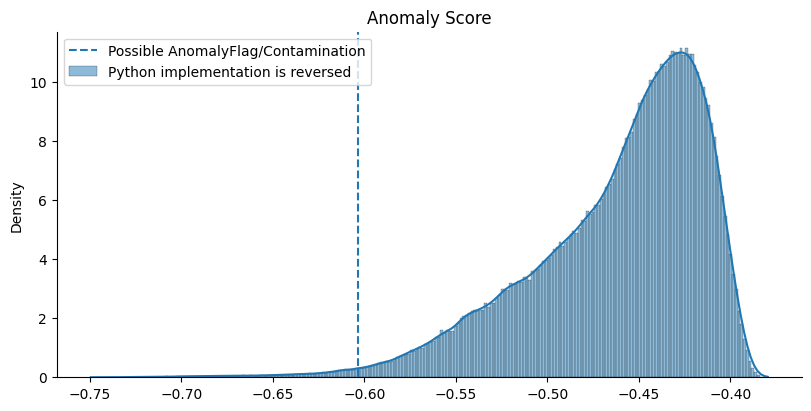

In [9]:
fig, ax = plt.subplots(layout='constrained',figsize=(8, 4))
sns.histplot(pd.Series(score_training), kde=True,stat="density",ax = ax,label = "Python implementation is reversed")
ax.spines[['right', 'top']].set_visible(False)
plt.axvline(np.percentile(score_training,1),linestyle = "--",label="Possible AnomalyFlag/Contamination")
plt.legend()
ax.set_title("Anomaly Score")

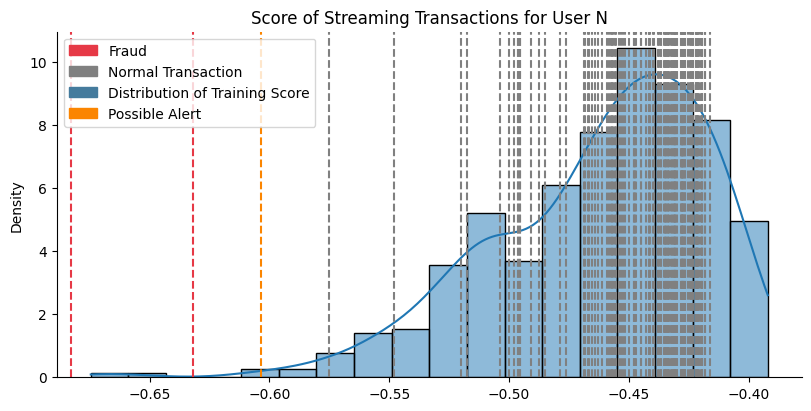

In [29]:
import time 
import matplotlib.patches as mpatches
fig, ax = plt.subplots(layout='constrained',figsize=(8, 4))
sns.histplot(pd.Series(score_training).sample(500), kde=True,stat="density",ax = ax,label = "Distribution of Anomaly Score in Past TRX")
plt.axvline(np.percentile(score_training,1),linestyle = "--",label="Possible AnomalyFlag/Contamination",color = "#fb8500")
user_trx =  user_trx_total.loc[ ( user_trx_total["TX_DATETIME"].dt.date >  datetime.date(2018,4,1) )  & ( user_trx_total["TX_DATETIME"].dt.date <  datetime.date(2018,6,1)  ) ]
last_trx_idx = user_trx.index[-1]
for i in range(100):
    #time.sleep(0.1)
    last_trx_idx+=1
    user_trx  = user_trx_total.iloc[0:last_trx_idx,:]
    X_test = create_feature_matrix(user_trx,windows_size_in_days = [1,5,7,15,30],delay_period=7).tail(1)
    score = model.score_samples(X_test[features])[0]
    #print(f"Score of Isolation forest: {scores[0]}")
    #display( user_trx.tail(1) )
    if user_trx["TX_FRAUD"].tail(1).item() == 1:
        ax.axvline(score,linestyle = "--", color="#e63946")
    else:
        ax.axvline(score,linestyle = "--", color="grey")
        

red_patch = mpatches.Patch(color='#e63946', label='Fraud')
blue_patch = mpatches.Patch(color='grey', label='Normal Transaction')
dist_patch = mpatches.Patch(color='#457b9d', label='Distribution of Training Score')
flag_patch = mpatches.Patch(color='#fb8500', label='Possible Alert')
ax.spines[['right', 'top']].set_visible(False)
ax.set_title("Score of Streaming Transactions for User N")
plt.legend(handles = [red_patch,blue_patch,dist_patch,flag_patch])
plt.show()

In [30]:
fig.savefig('anomaly_score_api.png',transparent=True)